# Homework # 10: Surfs Up! Advance Data Storage and Retreival
# Step 1: Climate Analysis and Exploration

In [57]:
# Import Matplot lib
import matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

## I. Reflect Tables into SQLAlchemy ORM and explore data

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [59]:
# Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found using SQLAlchemy
Base.classes.keys()

['measurement', 'station']

In [60]:
# Reflect database to ORM (Captialize M and S to indicate the reflection)
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

In [61]:
# Use Inspector to print the data types for each column
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [62]:
# Using SQLAlchemy to preview rows of data
results = session.query(Measurement.id, Measurement.station,\
Measurement.date, Measurement.prcp, Measurement.tobs).limit(5).all()
results

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [63]:
# Last date in source data  
last_date_query= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date= (last_date_query[0][:10])
last_date

'2017-08-23'

In [64]:
# Calculate the date 1 year ago from the last data point in the database
# start_12 = dt.date((year),(month),(day)) - dt.timedelta(days=365)
start_12 = dt.date(2017,8,23) - dt.timedelta(days=365)
start_12
# type(start_12)

datetime.date(2016, 8, 23)

## II. Precipitation Analysis

### Data queries and exploration

In [65]:
# Query Measurement table for last 12 months for only `date` and `prcp` and save into 'results' 
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >=start_12).\
    order_by(Measurement.date).all()

rain_df=pd.DataFrame(results,columns=['Date','Precipitation']).set_index('Date')
rain_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


### Results: Precipitation (Precipitation bar chart)

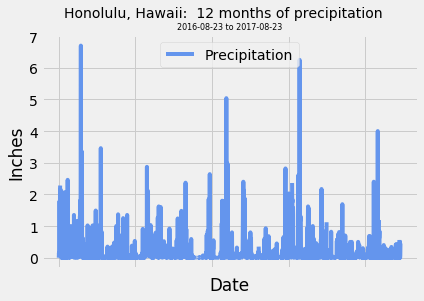

In [66]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(color='cornflowerblue', x_compat=True)
plt.suptitle('Honolulu, Hawaii:  12 months of precipitation',fontsize=14)
plt.title(f"{start_12} to {last_date}", fontsize=8)
plt.ylabel('Inches')
plt.legend(loc='upper center')
# Save image
plt.savefig("images/Precipitation_bar.png")

### Results: Precipitation (Descriptive statistics for precipitation data)

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# III. Weather Station Analysis

### Data queries and exploration

In [68]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [69]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

### Results: Weather Station (Total number of weather stations)

In [70]:
# Design a query to count totla number of stations
total_station = session.query(Station.station).count()

print(f"{total_station}: Total number of weather stations -- Honolulu, Hawaii")

9: Total number of weather stations -- Honolulu, Hawaii


In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
s_results = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(-func.count(Measurement.station)).all()

station_df=pd.DataFrame(s_results,columns=['Weather Station','Observation Count'])

### Results: Weather Station (List of active weather stations with observation counts)

In [72]:
# List the active weather stations and the observation counts in descending order
station_df 

,Weather Station,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


### Results: Weather Station (Most active weather station)

In [73]:
# Print the weather station wth the highest number of observations
most_active_station=(s_results[0][0])
print(f'{most_active_station} is the weather statio with the highest observation count ({s_results[0][1]}).')

USC00519281 is the weather statio with the highest observation count (2772).


### Results: Weather Station (Describe temperature - most active weather station)

In [74]:
#Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature most active station?

station_temp=session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
        filter(Measurement.station == most_active_station).all()

print(f'Weather station {most_active_station} temperatures: {station_temp} (min,avg,max)')

Weather station USC00519281 temperatures: [(54.0, 71.66378066378067, 85.0)] (min,avg,max)


### Results: Weather Station (Last 12 months of temperature data for most active weather station)

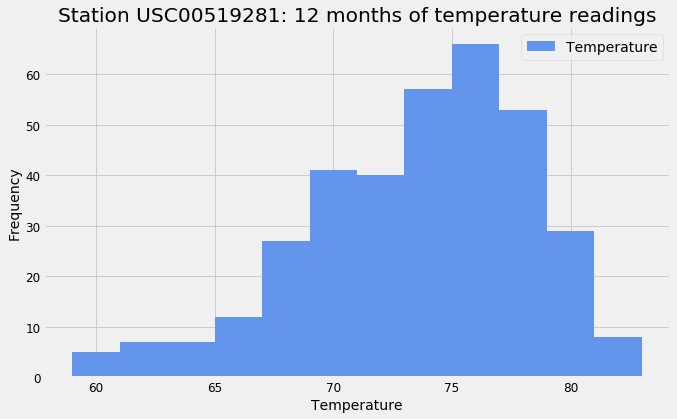

In [75]:
# Query the last 12 months of temperature observation data for this STATION
largest_station = session.query(Measurement.tobs).filter(Measurement.date >=start_12).\
filter(Measurement.station == most_active_station).all()
                                                         
# Save the query results as a Pandas DataFrame
station_df=pd.DataFrame(largest_station,columns=['Temperature'])

# Plot the results as a histogram
station_df.plot.hist(bins=12, title=(f"Station {most_active_station}: 12 months of temperature readings"),grid=True, figsize=(10,6), fontsize=12, color='cornflowerblue')
plt.ylabel('Frequency', size=14)
plt.xlabel('Temperature', size=14)
plt.legend(loc=1, prop={'size': 14})

# Save image
plt.savefig("images/Station_histogram.png")

## IV. Temperature Analysis

In [76]:
# These are my "pretend trip" dates.
start_date='2016-12-31'
end_date='2017-1-10'

# Temperature function for calculating min, avg, max temperatures over range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

### Results: Temperature Analysis (My trip dates - min, avg, max)

In [77]:
# Temperature function executed for my trip dates
temp_my_dates=calc_temps(start_date, end_date)
print(temp_my_dates)

[(58.0, 74.12268188302426, 87.0)]


In [78]:
# Scratch
# start='8-23-2016'
start='2016-8-23'
result=session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),\
                     func.max(Measurement.tobs)).filter(Measurement.date >=start).all()
result

[(58.0, 74.14387974230493, 87.0)]

In [79]:
# Scratch
# start='2016-8-23'
end='2017-8-23'
result=session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                     func.max(Measurement.tobs)).filter(Measurement.date >= start).filter(Measurement.date <= end).all()
result    

[(58.0, 74.14387974230493, 87.0)]

### Results: Temperature Anlysis (My dates - Bar chart - min, avg, max)

C:\Users\Laura\Anaconda3\envs\pythondata\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


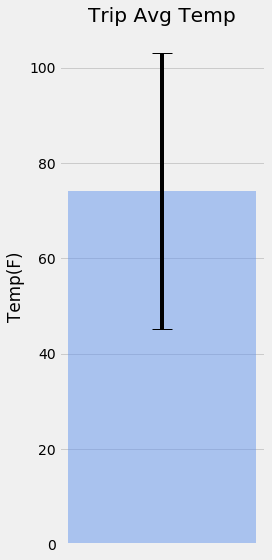

In [80]:
# Create Bar chart with y error bar
min=temp_my_dates[0][0]
avg=temp_my_dates[0][1]
max=temp_my_dates[0][2]
fig,ax=plt.subplots(figsize=plt.figaspect(2.))
xpos=1
bar=ax.bar(xpos,avg,yerr=(max-min), align='center', alpha=0.5, color='cornflowerblue', capsize=10)
ax.set(xticks=range(xpos),xticklabels='temperature',title='Trip Avg Temp', ylabel='Temp(F)')
fig.tight_layout()
fig.show()

# Save image
fig.savefig("images/Temperature_bar_error.png")